# Simple LSTM for track finding on 1D detector layers

In [18]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_event, draw_2d_input_and_pred, draw_train_history
from metrics import calc_hit_accuracy

from matplotlib import pyplot as plt
%matplotlib notebook

## Data generation

In [4]:
# Detector parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
seed_size = 5

In [2]:
def batch_generator(num_events, det_shape, num_bkg_tracks, noise_prob,
                    seed_size, binary=True):
    while True:
        # Generate signal tracks in the masked region
        sig_tracks = generate_straight_tracks(num_events, det_shape)
        # Generate track background
        bkg_tracks = generate_track_bkg(num_events, det_shape,
                                        tracks_per_event=num_bkg_tracks,
                                        skip_layers=seed_size)
        # Generate noise background
        noise = generate_uniform_noise(num_events, det_shape,
                                       prob=noise_prob)
        # Combine into full events
        events = sig_tracks + bkg_tracks + noise
        if binary:
            events[events > 1] = 1

        # Mask the data
        yield events, sig_tracks

## Simple LSTM track finding model

In [3]:
def build_model(num_hidden, det_shape,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=det_shape)
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(det_shape[1], activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## Single tracks with uniform noise

Here we look at events with 20% uniform binary noise hits and one signal track. The goal of the LSTM is to select the pixels belonging to the target track.

In [5]:
# Data config
num_bkg_tracks = 0
noise_prob = 0.2

# Model config
num_hidden = 50

# Training config
batch_size = 128
num_epoch = 10
epoch_size = 102400

In [9]:
# Prepare the batch generator
batcher1 = batch_generator(batch_size, det_shape,
                           num_bkg_tracks=num_bkg_tracks,
                           noise_prob=noise_prob, seed_size=seed_size)

# Prepare the model
model1 = build_model(num_hidden, det_shape)
model1.summary()

# Train the model
history1 = model1.fit_generator(batcher1, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

<IPython.core.display.Javascript object>


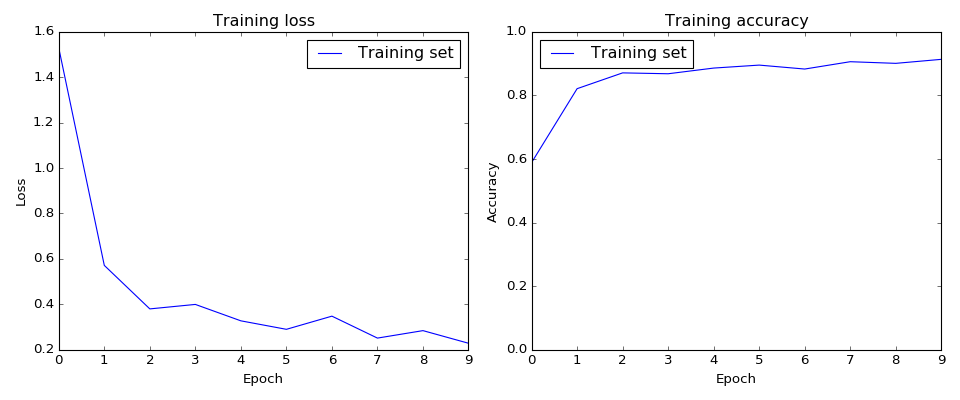

In [12]:
draw_train_history(history1, draw_val=False);

In [21]:
# Generate a test set
num_test = 10240
test1_input, test1_target = batch_generator(
    num_test, det_shape, num_bkg_tracks=num_bkg_tracks,
    noise_prob=noise_prob, seed_size=seed_size).next()

# Get test set predictions
test1_pred = model1.predict(test1_input)
test1_loss, test1_acc = model1.evaluate(test1_input, test1_target)

10144/10240 [============================>.] - ETA: 0s

In [22]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test1_pred, test1_target,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
test1_scores = test1_pred * test1_input
hit_accuracy = calc_hit_accuracy(test1_scores, test1_target)

# Print a test set summary
print('Test set loss', test1_loss)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Test set loss 0.205111718038
Accuracy of predicted pixel: 0.912536892361
Accuracy of classified hit:  0.923345703125


<IPython.core.display.Javascript object>


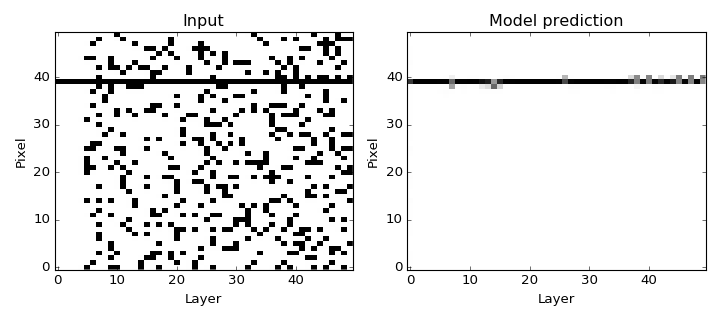

<IPython.core.display.Javascript object>


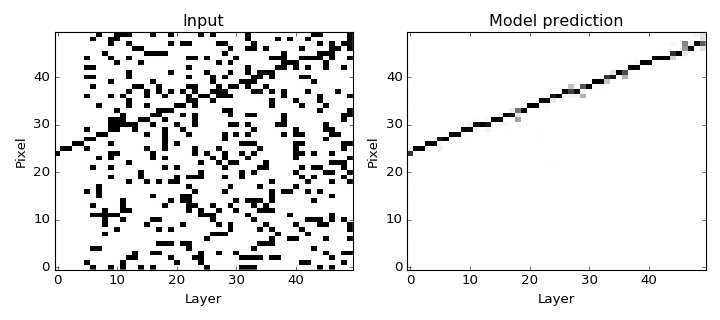

<IPython.core.display.Javascript object>


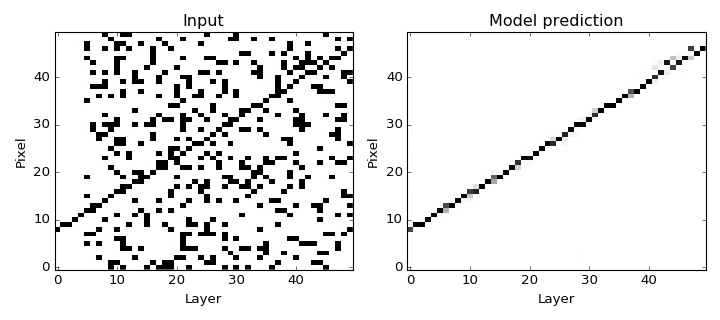

In [23]:
# Visualize predictions
for i in [0, 1, 2]:
    draw_2d_input_and_pred(test1_input[i], test1_pred[i], cmap='gray_r');

## Multi-track background

Now let's try the scenario where each event has background tracks in addition to the signal track, but no noise.

In [30]:
# Data config
num_bkg_tracks = 5
noise_prob = 0

# Model config
num_hidden = 100

# Training config
batch_size = 128
num_epoch = 10
epoch_size = 102400

In [31]:
# Prepare the batch generator
batcher2 = batch_generator(batch_size, det_shape,
                           num_bkg_tracks=num_bkg_tracks,
                           noise_prob=noise_prob, seed_size=seed_size)

# Prepare the model
model2 = build_model(num_hidden, det_shape)
model2.summary()

# Train the model
history2 = model2.fit_generator(batcher2, samples_per_epoch=epoch_size,
                                nb_epoch=num_epoch)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 50, 50)        0                                            
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 50, 100)       60400       input_3[0][0]                    
____________________________________________________________________________________________________
timedistributed_3 (TimeDistribut (None, 50, 50)        5050        lstm_3[0][0]                     
Total params: 65,450
Trainable params: 65,450
Non-trainable params: 0
____________________________________________________________________________________________________
Epoch 1/10
102400/102400 [==============================] - 53s - loss: 1.4859 - acc: 0.5380    
Epoch 2/10
102400/102400 

<IPython.core.display.Javascript object>


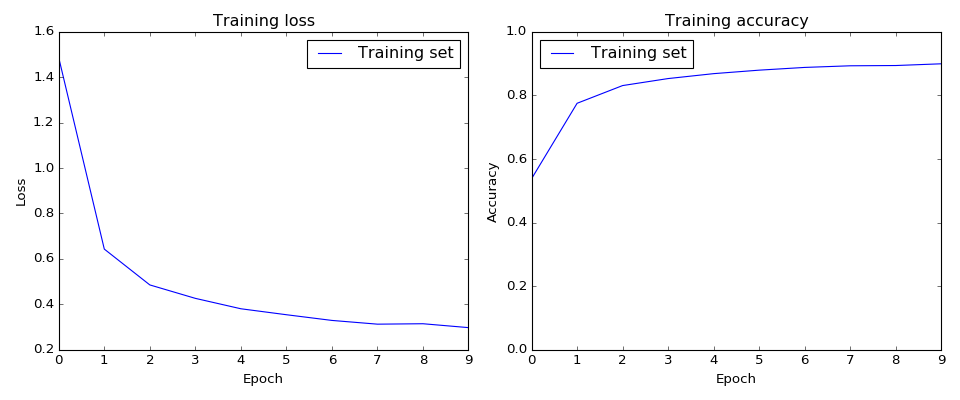

In [32]:
draw_train_history(history2, draw_val=False);

In [33]:
# Generate a test set
num_test = 10240
test2_input, test2_target = batch_generator(
    num_test, det_shape, num_bkg_tracks=num_bkg_tracks,
    noise_prob=noise_prob, seed_size=seed_size).next()

# Get test set predictions
test2_pred = model2.predict(test2_input)
test2_loss, test2_acc = model2.evaluate(test2_input, test2_target)

10144/10240 [============================>.] - ETA: 0s

In [34]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test2_pred, test2_target,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
test2_scores = test2_pred * test2_input
hit_accuracy = calc_hit_accuracy(test2_scores, test2_target)

# Print a test set summary
print('Test set loss', test2_loss)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Test set loss 0.27365219004
Accuracy of predicted pixel: 0.896395399306
Accuracy of classified hit:  0.907126953125


<IPython.core.display.Javascript object>


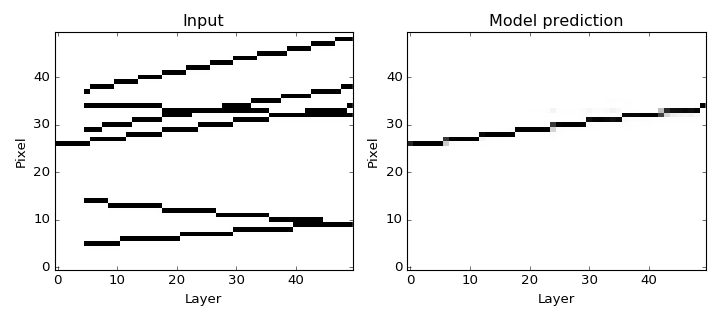

<IPython.core.display.Javascript object>


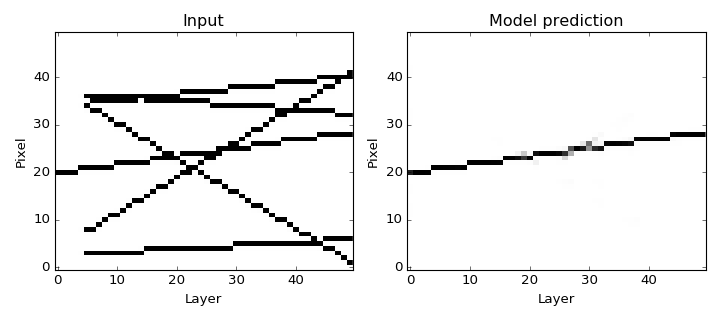

<IPython.core.display.Javascript object>


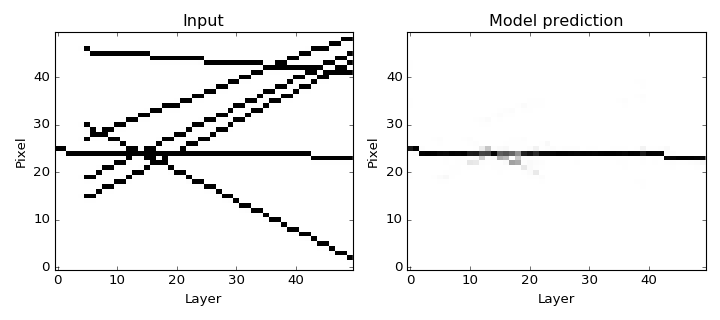

In [35]:
# Visualize predictions
for i in [0, 1, 2]:
    draw_2d_input_and_pred(test2_input[i], test2_pred[i], cmap='gray_r');